# Load modules and model

In [1]:
from dynamita.sumo import *

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from collections import OrderedDict

from SALib.sample import saltelli, latin
from sklearn import preprocessing
import json
# from sklearn.metrics import 

%matplotlib inline

In [2]:
# allows me to store current notebook position
if not 'nbookDir' in globals():
    nbookDir = os.getcwd()

## Load SUMO and its license

In [3]:
sumo = Sumo(sumoPath = r"C:/Program Files (x86)/Dynamita/Sumo19/",
            licenseFile = r"C:/Program Files (x86)/Dynamita/GiacomoBellandi2020.sumodyn")

# sumo = Sumo(sumoPath=r"/media/giacomo/CE82DCC682DCB3E5/Program Files (x86)/Dynamita/Sumo19/",
#             licenseFile=r"/media/giacomo/CE82DCC682DCB3E5/Program Files (x86)/Dynamita/Sumo19/GiacomoBellandi2019.sumodyn")

License OK...


## Define callback functions

In [4]:
def datacomm_callback(sumo):
    t.append(sumo.core.csumo_var_get_time_double(sumo.handle))
    sBentazConv.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, sBentazConv_pos))
    sAtrazConv.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, sAtrazConv_pos))
    sIsoprConv.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, sIsoprConv_pos))
    sIbuprConv.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, sIbuprConv_pos))
    sMetfoConv.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, sMetfoConv_pos))
    sCarbaConv.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, sCarbaConv_pos))
    sMetopConv.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, sMetopConv_pos))
    sTrimeConv.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, sTrimeConv_pos))
    sIoproConv.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, sIoproConv_pos))
    sPhenaConv.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, sPhenaConv_pos))
    sDicloConv.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, sDicloConv_pos))
    sUVtot.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, sUVtot_pos))
    return 0

In [5]:
def message_callback(sumo):
    for message in sumo.messages:
        print(message)
    sumo.messages = []
    return 0

This command below lets Sumo know about our custom datacomm function:

In [6]:
sumo.register_message_callback(message_callback)

## Load SUMO model

In [7]:
sumo.unload_model()

No model is loaded


<b> Open the Sumo project and run a small simulation, check in the Core window where the tmp files are located and copy the directory here below </b>

In [8]:
# Where your model temp files are stored (check the core window), this needs to be renewed every time we open sumo
modelpath = r"C:/Users/bella/AppData/Local/Dynamita/Sumo19/.tmp/r0n35aff.shk/"

In [9]:
os.chdir(nbookDir)
sumo.load_model('../O3v8D_GOBAMpilot_v4.sumo')

530021 Set: Sumo__StopTime to 0
530021 Set: Sumo__DataComm to 3600000
530021 Set: Sumo__PlantName to C:\Users\bella\AppData\Local\Dynamita\Sumo19\TMP~1\2birmaku.lxt\SUMOPR~2.XML
530049 Core loop started.


0

In [10]:
sumo.register_datacomm_callback(datacomm_callback)

# Multi-parametric variation

## Store initial values of kinetic parameters

In [11]:
## We have to manually set the initial values of non-default params
# Defines a library of the non-default params values to edit
parasets = pd.DataFrame({'kO3': 172.8,
#                           'kO3_UVA_R1': 7775999.99999998,
#                           'kO3_UVA_R2': 777599.999999998,
#                           'YO3_UVA_R1': 0.011,
#                           'YO3_UVA_R2': 0.005,
#                           'n1': 0.55,
#                           'n2': 0.1,
#                           'YHOCl_UVA_R1': 0.01,
#                           'kHOCl_UVA_R1': 8.6400E08,
#                           'FScav': 3455999999.99999,
#                           'kHO_dot_Atrazine': 216000000000,
#                           'kBr_dot_DOC': 8639999999.99998,
#                           'kO3_HO2m': 24191999.9999999,
                          'kL_GO2_bub': 0.
                        }, 
                         index=[0])

## create par set

Since we're fitting MPs conversion and UV data, we're modifying the variables for UV consumption, HO* production, HO* scavenging, and the reaction of O3 with HO2-

In [11]:
# os.chdir(nbookDir)
# parasets = pd.read_pickle('./parasets_8pars_50ksamples')

In [36]:
## here we define the domain of each parameter we want to vary
problem = {
  'num_vars': 8,
  'names': ['kO3_UVA_R1', 'kO3_UVA_R2', 
            'YO3_UVA_R1', 'YO3_UVA_R2',
            'n1', 'n2',
            'FScav', 'kO3_HO2m'],
  'bounds': [[1e5, 1e7], [1e4, 1e6],
            [0.001, 0.1], [1e-4, 0.01],
            [0.01, 0.7], [0.01, 0.6],
            [1e8, 1e10], [1e7, 3e8]]}

# Generate samples
param_values = latin.sample(problem, 2) #calc_second_order=False)
param_values = pd.DataFrame(param_values, columns=problem['names']) 

In [37]:
# builds the dataframe of parameter avlues adding also the parameters that we're not changing in the different scenarios
for i in parasets.columns:
     if i not in param_values.columns:
            param_values[i] = parasets[i][0]
parasets = param_values

In [34]:
parasets[0:1]

,kO3_UVA_R1,kO3_UVA_R2,YO3_UVA_R1,YO3_UVA_R2,n1,n2,FScav,kO3_HO2m,kO3,kL_GO2_bub
0,3.927654e+06,389218.086124,0.081085,0.009275,0.574778,0.134208,5.373611e+09,2.909196e+08,172.8,0.0


In [35]:
parasets[1235:1240]

,kO3_UVA_R1,kO3_UVA_R2,YO3_UVA_R1,YO3_UVA_R2,n1,n2,FScav,kO3_HO2m,kO3,kL_GO2_bub
1235,5.951825e+06,586583.795478,0.056139,0.004750,0.096388,0.206281,5.176174e+08,5.838889e+07,172.8,0.0
1236,4.244311e+06,328960.938522,0.084215,0.006531,0.415446,0.011123,6.161568e+09,1.005029e+08,172.8,0.0
1237,5.000310e+06,395133.335955,0.072027,0.002986,0.070585,0.148554,4.258832e+09,2.958413e+08,172.8,0.0
1238,5.285577e+06,389402.468421,0.044194,0.004364,0.410976,0.387960,1.382970e+09,2.062097e+08,172.8,0.0
1239,8.618463e+06,688383.246015,0.077672,0.004783,0.511711,0.140257,8.129286e+09,1.804734e+08,172.8,0.0


In [17]:
# os.chdir(nbookDir)
# parasets.to_pickle('./parasets_8pars_50ksamples')

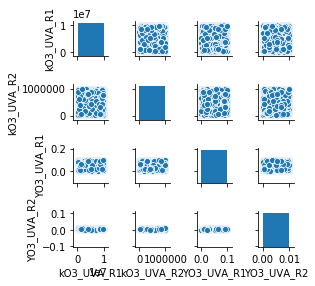

In [23]:
sns.pairplot(param_values[problem['names']], height=1); # plotting only the sampled ones

# Run!

In [36]:
# Get variables position
sBentazConv_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__BentazoneConv')
sAtrazConv_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__AtrazineConv')
sIsoprConv_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__IsoproturonConv')
sIbuprConv_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__IbuprofenConv')
sMetfoConv_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__MetforminConv')
sCarbaConv_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__CarbamazepineConv')
sMetopConv_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__MetoprololConv')
sTrimeConv_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__TrimethoprimConv')
sIoproConv_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__IopromideConv')
sPhenaConv_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__PhenazoneConv')
sDicloConv_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__DiclofenacConv')
sUVtot_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__CSTR8__SUVA_tot')

In [37]:
sumo.set_stopTime(300000) # ms
sumo.set_dataComm(1000) # ms

530021 Set: Sumo__StopTime to 300000
530021 Set: Sumo__DataComm to 1000


In [38]:
# %%capture capt
# Magic to suppress the output of the cel and store it in capt

# Initialize storage variables
# BentazConv_modeled = OrderedDict()
# AtrazConv_modeled = OrderedDict()
# IsoprConv_modeled = OrderedDict()
# IbuprConv_modeled = OrderedDict()
# MetfoConv_modeled = OrderedDict()
# CarbaConv_modeled = OrderedDict()
# MetopConv_modeled = OrderedDict()
# TrimeConv_modeled = OrderedDict()
# IoproConv_modeled = OrderedDict()
# PhenaConv_modeled = OrderedDict()
# DicloConv_modeled = OrderedDict()
# UVtot_modeled = OrderedDict()

# os.chdir(nbookDir)
# with open('modeloutput_20110928.json', 'w') as f:
#     dictionaries = [BentazConv_modeled, AtrazConv_modeled,
#                     IsoprConv_modeled, IbuprConv_modeled]
#     f.write(json.dumps(dictionaries))

pd.DataFrame({'BentazConv_modeled': [],
              'AtrazConv_modeled' : [],
              'IsoprConv_modeled': []}).to_csv('./trialcsv_20110928.csv', mode='w')

# Params initialization
for row in parasets[1235:1240].index:
    print('Simulation '+str(row+1)) # simulation number
    
#     set non-default volumes and params
    command = str('execute ' + str(modelpath) + '/script_Initialize.scs')
    sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))
    
#     set specific scenario
    command = 'execute ./scenario.scs'
    sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))
    
#     set initial concentrations
#     sumo.send_command('loadstates "' +str(modelpath)+'/lastrun.ss'+'"'+' -partial 1 -maptoic')    
    sumo.send_command('loadstates "./lastrun.ss" -partial 1 -maptoic')    
    
#     set user script
    command = str('execute ./userscript.txt')
    sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))
    
    for n in parasets.iloc[[row]]:
        command = 'set Sumo__Plant__param__Ozone_v8D__' + n + ' ' + str(parasets[n].values[row]) + ';'
        sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))
        
    # Initialize lists
    t = []
    sBentazConv = []
    sAtrazConv = []
    sIsoprConv = []
    sIbuprConv = []
    sMetfoConv = []
    sCarbaConv = []
    sMetopConv = []
    sTrimeConv = []
    sIoproConv = []
    sPhenaConv = []
    sDicloConv = []
    sUVtot = []

    # Let's have Sumo do some work
    sumo.run_model()
    
    # The run_model is an asynchronous call, so we need to wait until
    # the current run is finished, otherwise we would mess up our simulations
    while not sumo.simulation_finished:
        time.sleep(0.01)

#     # Good, we got our data in the list, let's store 'em in our dictionary, using 
#     # scenario as the label
#     BentazConv_modeled[row] = np.mean(sBentazConv[-50:])
#     AtrazConv_modeled[row] = np.mean(sAtrazConv[-50:]) 
#     IsoprConv_modeled[row] = np.mean(sIsoprConv[-50:])
#     IbuprConv_modeled[row] = np.mean(sIbuprConv[-50:])
#     MetfoConv_modeled[row] = np.mean(sMetfoConv[-50:])
#     CarbaConv_modeled[row] = np.mean(sCarbaConv[-50:])
#     MetopConv_modeled[row] = np.mean(sMetopConv[-50:])
#     TrimeConv_modeled[row] = np.mean(sTrimeConv[-50:])
#     IoproConv_modeled[row] = np.mean(sIoproConv[-50:])
#     PhenaConv_modeled[row] = np.mean(sPhenaConv[-50:])
#     DicloConv_modeled[row] = np.mean(sDicloConv[-50:])
#     UVtot_modeled[row] = np.mean(sUVtot[-50:]) 

#     os.chdir(nbookDir)
#     with open('modeloutput_20110928.json', 'a') as f:
#         dictionaries = [np.mean(sBentazConv[-50:]), np.mean(sAtrazConv[-50:]),
#                         np.mean(sIsoprConv[-50:]), np.mean(sIbuprConv[-50:])]
#         f.write(json.dumps(dictionaries))
    os.chdir(nbookDir)
    pd.DataFrame({'BentazConv_modeled': np.mean(sBentazConv[-50:]),
              'AtrazConv_modeled' : np.mean(sAtrazConv[-50:]),
              'IsoprConv_modeled': np.mean(sIsoprConv[-50:])}, index=[row]).to_csv('./trialcsv_20110928.csv', 
                                                                                   mode='a',
                                                                                   header=False)

Simulation 1236
530036 Script file C:/Users/bella/AppData/Local/Dynamita/Sumo19/.tmp/r0n35aff.shk//script_Initialize.scs loaded.
530007 Path set to: "C:/Users/bella/AppData/Local/Dynamita/Sumo19/.tmp/r0n35aff.shk".
530020 Set mode: dynamic
530021 Set: Sumo__Plant__param__Ozone_v8D__kO3 to 172.8
530021 Set: Sumo__Plant__param__Ozone_v8D__kO3_UVA_R1 to 7.776e+06
530021 Set: Sumo__Plant__param__Ozone_v8D__kO3_UVA_R2 to 777600
530021 Set: Sumo__Plant__param__Ozone_v8D__YO3_UVA_R1 to 0.011
530021 Set: Sumo__Plant__param__Ozone_v8D__YO3_UVA_R2 to 0.005
530021 Set: Sumo__Plant__param__Ozone_v8D__n1 to 0.55
530021 Set: Sumo__Plant__param__Ozone_v8D__n2 to 0.1
530021 Set: Sumo__Plant__param__Ozone_v8D__kHOCl_UVA_R1 to 8.64e+08
530021 Set: Sumo__Plant__param__Ozone_v8D__FScav to 3.456e+09
530021 Set: Sumo__Plant__param__Ozone_v8D__kHO_dot_Atrazine to 2.16e+11
530021 Set: Sumo__Plant__param__Ozone_v8D__kBr_dot_DOC to 8.64e+09
530021 Set: Sumo__Plant__param__Ozone_v8D__kO3_HO2m to 2.4192e+07
53002

530004 Simulation ended.
Simulation 1238
530036 Script file C:/Users/bella/AppData/Local/Dynamita/Sumo19/.tmp/r0n35aff.shk//script_Initialize.scs loaded.
530007 Path set to: "C:/Users/bella/AppData/Local/Dynamita/Sumo19/.tmp/r0n35aff.shk".
530020 Set mode: dynamic
530021 Set: Sumo__Plant__param__Ozone_v8D__kO3 to 172.8
530021 Set: Sumo__Plant__param__Ozone_v8D__kO3_UVA_R1 to 7.776e+06
530021 Set: Sumo__Plant__param__Ozone_v8D__kO3_UVA_R2 to 777600
530021 Set: Sumo__Plant__param__Ozone_v8D__YO3_UVA_R1 to 0.011
530021 Set: Sumo__Plant__param__Ozone_v8D__YO3_UVA_R2 to 0.005
530021 Set: Sumo__Plant__param__Ozone_v8D__n1 to 0.55
530021 Set: Sumo__Plant__param__Ozone_v8D__n2 to 0.1
530021 Set: Sumo__Plant__param__Ozone_v8D__kHOCl_UVA_R1 to 8.64e+08
530021 Set: Sumo__Plant__param__Ozone_v8D__FScav to 3.456e+09
530021 Set: Sumo__Plant__param__Ozone_v8D__kHO_dot_Atrazine to 2.16e+11
530021 Set: Sumo__Plant__param__Ozone_v8D__kBr_dot_DOC to 8.64e+09
530021 Set: Sumo__Plant__param__Ozone_v8D__kO3

530004 Simulation ended.
Simulation 1240
530036 Script file C:/Users/bella/AppData/Local/Dynamita/Sumo19/.tmp/r0n35aff.shk//script_Initialize.scs loaded.
530007 Path set to: "C:/Users/bella/AppData/Local/Dynamita/Sumo19/.tmp/r0n35aff.shk".
530020 Set mode: dynamic
530021 Set: Sumo__Plant__param__Ozone_v8D__kO3 to 172.8
530021 Set: Sumo__Plant__param__Ozone_v8D__kO3_UVA_R1 to 7.776e+06
530021 Set: Sumo__Plant__param__Ozone_v8D__kO3_UVA_R2 to 777600
530021 Set: Sumo__Plant__param__Ozone_v8D__YO3_UVA_R1 to 0.011
530021 Set: Sumo__Plant__param__Ozone_v8D__YO3_UVA_R2 to 0.005
530021 Set: Sumo__Plant__param__Ozone_v8D__n1 to 0.55
530021 Set: Sumo__Plant__param__Ozone_v8D__n2 to 0.1
530021 Set: Sumo__Plant__param__Ozone_v8D__kHOCl_UVA_R1 to 8.64e+08
530021 Set: Sumo__Plant__param__Ozone_v8D__FScav to 3.456e+09
530021 Set: Sumo__Plant__param__Ozone_v8D__kHO_dot_Atrazine to 2.16e+11
530021 Set: Sumo__Plant__param__Ozone_v8D__kBr_dot_DOC to 8.64e+09
530021 Set: Sumo__Plant__param__Ozone_v8D__kO3

In [39]:
pd.read_csv('./trialcsv_20110928.csv', index_col=[0])

,BentazConv_modeled,AtrazConv_modeled,IsoprConv_modeled
1235,0.390204,0.164535,0.427214
1236,0.372744,0.255410,0.589893
1237,0.351342,0.065623,0.195842
1238,0.540110,0.459908,0.834305
1239,0.243064,0.257625,0.589428


## OR you may want to load/write the data

In [2]:
# pd.to_pickle(so3_sensitivity_data, './BatchCal_50k_so3_scen13R_kO3fix.pkl')
# pd.to_pickle(parasets, './BatchCal_50k_pars_scen13R_kO3fix.pkl')
# so3_sensitivity_data = pd.read_pickle('./BatchCal_50k_so3_scen13R_kO3fix.pkl')
# parasets = pd.read_pickle('./BatchCal_50k_pars_scen13R_kO3fix.pkl')

## Plotting (currently not advisable with high number of simulations)

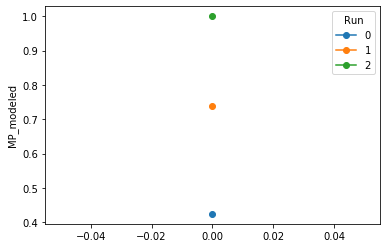

In [34]:
fig, axes = plt.subplots(1,1)
# axes.set_xlabel('time')
axes.set_ylabel('MP_modeled')

for run, MP in BentazConv_modeled.items():
    axes.plot(MP, label=str(run), marker='o')
    plt.legend(loc='upper right', title='Run')
    fig.canvas.draw()
    
# axes.plot(Meas['Bentazone'], 'o')

# Read lab experiments

In [35]:
os.chdir(nbookDir)

In [36]:
Meas = pd.read_excel(r'../../../DuneaData/LabPilot/GOBAM PI Data.xlsx',
                      sheet_name='Tabel (6 -1,5)+Rel_par', usecols='A:P,AE', skiprows=1, nrows=10, index_col=0).dropna()

In [37]:
Meas['Bentazone']['2011-09-28']

97.60000000000001

# Calculate metrics

## functions

In [38]:
def calc_metrics3(modelled, observed):
    """
    Calucates metrics of comparison between modelled and observed variables
    
    -------
    Prameters
    
    modelled: array of floats or time serie
    observed: array of floats or time serie
    """
    
    residuals = np.abs(modelled - observed)
    df = pd.DataFrame({'MAE': np.mean([np.abs(residuals)]), ### MAE (mean absolute error) range: [0, inf] optimum: 0
                      'RMSE': np.mean([np.sqrt(residuals**2)]), ### RMSE (root mean sq error)
                      'MSE': np.mean([(residuals**2)]), ### MSE (mean sq error) range: [0, inf] optimum: 0
                      'MSLE': np.mean([((np.log(observed) - np.log(modelled))**2)]), ### MSLE (mean sq log error - emphasises low magnitude errors) range: [0, inf] optimum: 0
                      'RRMSE': np.mean([np.sqrt((residuals**2))])/np.mean(observed), ### RRMSE (relative root mean sq error)
                      'SSE': np.sum(residuals**2), ### SSE (sum of sq errors) range: [0, inf] optimum: 0
                      'AMRE': np.mean([np.abs(residuals/observed)]), ### AMRE (abs mean relative error [from MREin pystran]) range: [-inf, inf] optimum: 0
                      'MARE': np.mean([(np.abs(residuals)/observed)]), ### MARE (mean abs relative error) range: [0, inf] optimum: 0
                      'SARE': (np.abs(residuals)/observed).sum(axis=0), ### SARE (sum of abs relative error) range: [0, inf] optimum: 0
                      'MeAPE': np.median([(np.abs(residuals)*100./observed)]), ### MeAPE (median of absolute prediction error) range: [0, inf] optimum: 0
                      'MSRE': np.mean([((residuals/observed)**2)]), ### MSRE (mean sq relative error) range: [0, inf] optimum: 0
                      'RVE': np.sum([residuals])/np.sum([observed])}, ### RVE (relative vol error) range: [-inf, inf] optimum: 0
                      index=[0])
    return df

In [39]:
## Generating the matrix of scores arranged with metrics (columns) for each parameter set (rows)
def MPs_scores_matrix(modeled, measured):
    """
    Arranges the scores of the calc_metrics3 output in a dataframe according to the relative scenario
    
    -----------
    Parameters
    
    modeled: dictionary of scenarios with index of integers, values are float
    measured: float to be compared against the modeled
    
    """
    output_martix = pd.DataFrame()

    for scenario in modeled:
        a = calc_metrics3(modeled[scenario], measured)
        a.index = [scenario]
        output_martix = pd.concat([output_martix, a], axis=0, ignore_index=False)
    return(output_martix)

In [40]:
def scale_matrix_scores(scores):
    """
    Scales from 0 to 1 the values of the scores given from each metric to each scenario
    
    ------
    Parameters
    
    scores: DataFrame of metrics (columns) and scenarios as index
    """
    
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = pd.DataFrame(min_max_scaler.fit_transform(scores), columns=scores.columns)
    x_scaled['sum'] = x_scaled.sum(axis=1)
    x_scaled['scenario'] = scores.index
    x_scaled = x_scaled.set_index(x_scaled['sum'], drop=False).sort_index()
    return(x_scaled)

## calculate scores for exp '2011-09-28'

In [41]:
Bentaz_scores = MPs_scores_matrix(BentazConv_modeled, Meas['Bentazone']['2011-09-28'])
Atraz_scores = MPs_scores_matrix(AtrazConv_modeled, Meas['Atrazine']['2011-09-28'])
UVtot_scores = MPs_scores_matrix(UVtot_modeled, Meas['UV after O3 (1/m)']['2011-09-28'])
# Isopr_scores = MPs_scores_matrix(Isopr_modeled, Meas['Isoproturon']['28-09-2011'].values)

In [42]:
sumscores = Bentaz_scores + Atraz_scores + UVtot_scores

In [43]:
scaled_scores = scale_matrix_scores(sumscores)

# Visualization

[]

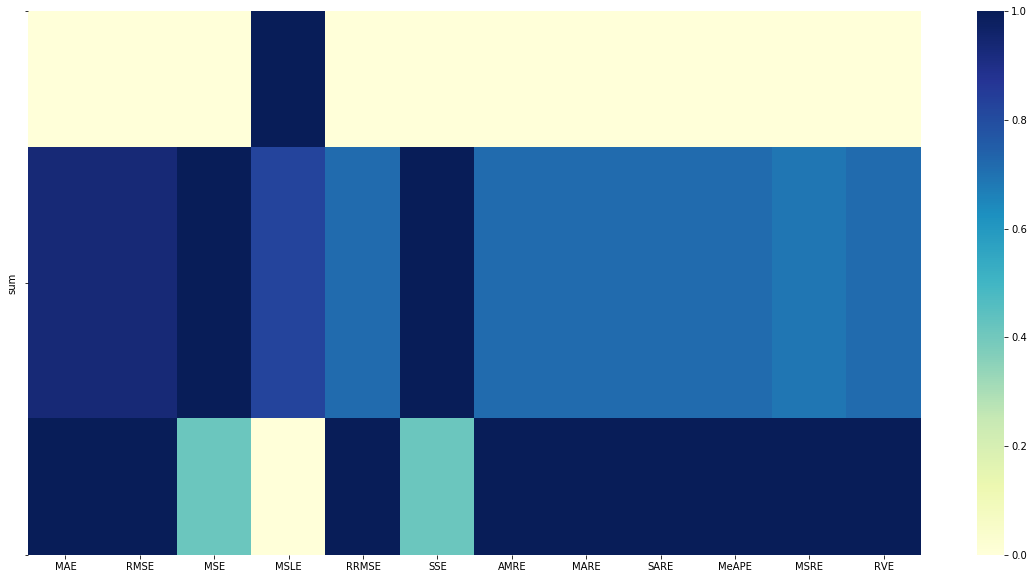

In [44]:
fig, ax1 = plt.subplots(figsize=(20, 10))
sns.heatmap(scaled_scores.drop(['scenario', 'sum'], axis=1)[:100], # plotting only the 12 metrics and the best 50 scenarios
            ax=ax1, annot=False, cmap="YlGnBu", )

# ax1.xaxis.set_major_locator(plt.MaxNLocator(nbins=13))
# ax1.set_xticklabels(df.columns.tolist()); # there is a bug in the set_ticklabels and the first label gets lost
ax1.set_yticklabels('')
# plt.savefig(r'./results/metricEval/CM/StSt/10000/rankscenario_nh.png', dpi=300)

## ..and the winner is

In [78]:
# the best n performing parsets
parasets.iloc[scaled_scores['scenario'].head(10)]#.to_excel('top10_O3_2_8_kO3fix.xlsx', engine='xlsxwriter')

,kO3_UVA_R1,kO3_UVA_R2,YO3_UVA_R1,YO3_UVA_R2,kO3,kL_GO2_bub
2,3.152719e+06,85344.635925,0.024320,0.003681,172.8,0.0
1,4.115133e+06,818664.928518,0.062877,0.009355,172.8,0.0
0,8.086471e+06,556031.416555,0.072588,0.000696,172.8,0.0


In [267]:
for i in scaled_scores['scenario'].head(5):
    print(str(i) + ' ' + str(calc_metrics3(Bentaz_modeled[i], Meas['Bentazone'].values)))

0          MAE       RMSE          MSE      MSLE     RRMSE          SSE  \
0  90.457262  90.457262  8182.516246  6.837081  0.926816  8182.516246   

       AMRE      MARE      SARE      MeAPE      MSRE       RVE  
0  0.926816  0.926816  0.926816  92.681621  0.858988  0.926816  
2          MAE       RMSE          MSE       MSLE     RRMSE          SSE  \
0  94.082733  94.082733  8851.560715  11.043614  0.963962  8851.560715   

       AMRE      MARE      SARE      MeAPE      MSRE       RVE  
0  0.963962  0.963962  0.963962  96.396243  0.929224  0.963962  
1          MAE       RMSE          MSE       MSLE     RRMSE          SSE  \
0  94.866063  94.866063  8999.569887  12.781589  0.971988  8999.569887   

       AMRE      MARE      SARE      MeAPE      MSRE       RVE  
0  0.971988  0.971988  0.971988  97.198835  0.944761  0.971988  


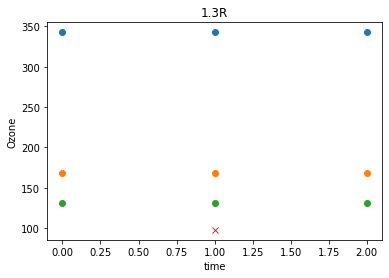

In [270]:
fig, axes = plt.subplots(1,1)
axes.set_xlabel('time')
axes.set_ylabel('Ozone')

winniers = pd.DataFrame(Bentaz_modeled, index=Bentaz_modeled.keys())[scaled_scores['scenario'].head(3)]

for run in winniers:
    axes.plot(winniers[run]*48, 'o')#, label=str(run))
#     plt.legend(loc='upper right', title='Run')
    plt.title('1.3R')
    fig.canvas.draw()
axes.plot(Meas['Bentazone'], marker='x', linestyle='');

In [263]:
threshold = 50
good = parasets[problem['names']].loc[scaled_scores['scenario'].head(threshold).values[:]]
bad = parasets[problem['names']].loc[scaled_scores['scenario'].tail(threshold*2).values[:]]
good['color'] = 'good'
bad['color'] = 'bad'
good_bad_nh = pd.concat([good, bad])

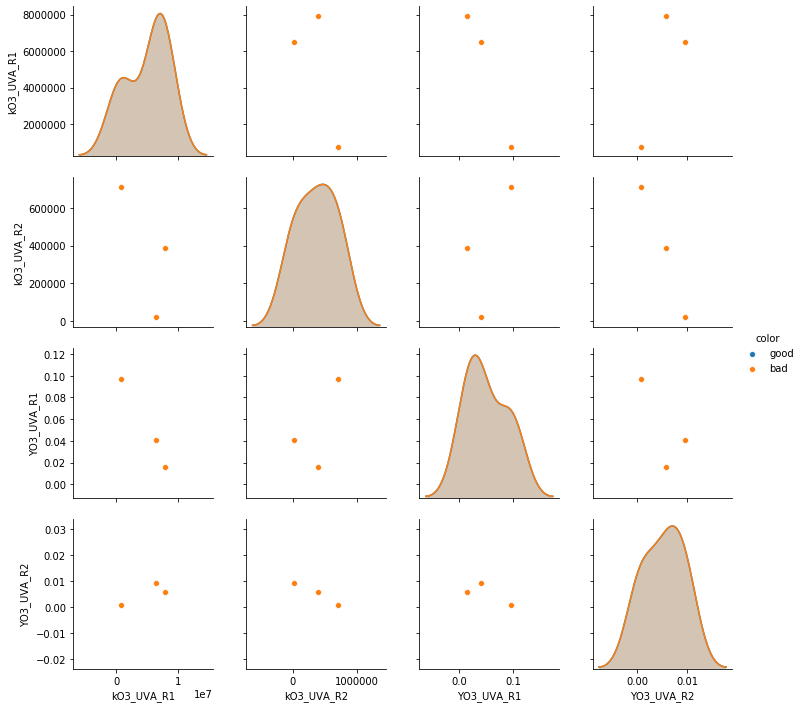

In [264]:
# plotting only those params that were varied and only the first n best performing
sns.pairplot(good_bad_nh, hue='color');